# Pruning a PyTorch Model

Pruning is a technique for reducing the size of a neural network by removing unimportant weights. The idea is to train a model, identify the unimportant weights, and then remove them. The resulting model will be smaller and faster, but will have the same accuracy as the original model.

![The pruning process](https://shrinkbench.github.io/diagram.svg)

```{tip} To learn more about what neural network pruning is, see this excellent [blog post](https://towardsdatascience.com/neural-network-pruning-101-af816aaea61) by [Hugo Tessier](https://medium.com/@hugo.tessier).
```

```{attention} 
> **For Contributors**: Source code for the pruning functionality resides under the `metinor.optimizer.pruning` module.
```

## Supported Pruning Strategies

There are many different ways to prune a neural network. In the `metinor.optimizer.pruning.strategies` package, we provide implementations of some of the most common pruning strategies.

Here is a brief overview of the pruning strategies available:

- **GlobalMagWeight (Global Magnitude Weight Pruning)**: Prunes the least important weights across the entire network based on their absolute values.
- **LayerMagWeight (Layerwise Magnitude Weight Pruning)**: Prunes weights within individual layers based on their absolute values.
- **GlobalMagGrad (Global Magnitude-Gradient Pruning)**: Prunes weights across the entire network based on a combination of their absolute values and gradients.
- **LayerMagGrad (Layerwise Magnitude-Gradient Pruning)**: Prunes weights within layers based on a combination of their absolute values and gradients.
- **GlobalMagAct (Global Activation-Magnitude Pruning)**: Prunes weights across the network based on a combination of their absolute values and corresponding activations.
- **LayerMagAct (Layerwise Activation-Magnitude Pruning)**: Prunes weights within layers based on a combination of their absolute values and corresponding activations.
- **RandomPruning**: Randomly zeroes out a fraction of weights across the entire network.

To list all available pruning strategies, use the `list_pruning_strategies` function:

In [1]:
from metinor.optimizer import list_pruning_strategies

strategies = list_pruning_strategies()
print(strategies)

['GlobalMagWeight', 'LayerMagWeight', 'GlobalMagGrad', 'LayerMagGrad', 'GlobalMagAct', 'LayerMagAct', 'RandomPruning']


## Implementing Your Own Pruning Strategy

The pruning package allows for easy application of different pruning strategies to neural network models. To implement a new pruning strategy, you need to extend one or more base classes from `LayerPruning` or `VisionPruning`. Then, you either need to implement `layer_masks` or `model_masks` depending on whether you want to prune layerwise or globally. For example, see the following implementations of global and layerwise magnitude pruning:

In [2]:
from metinor.optimizer.pruning import VisionPruning, LayerPruning


class GlobalMagWeight(VisionPruning):

    def model_masks(self):
        importances = map_importances(np.abs, self.params())
        flat_importances = flatten_importances(importances)
        threshold = fraction_threshold(flat_importances, self.fraction)
        masks = importance_masks(importances, threshold)
        return masks


class LayerMagWeight(LayerPruning, VisionPruning):

    def layer_masks(self, module):
        params = self.module_params(module)
        importances = {param: np.abs(value) for param, value in params.items()}
        masks = {param: fraction_mask(importances[param], self.fraction)
                for param, value in params.items() if value is not None}
        return masks

## Using the Pruning API

To prune a model, use the `prune` function by specifying the model, the pruning strategy, and strategy-specific parameters. For example, to prune a model using random pruning:

```python
from metinor.optimizer import prune

model = ...  # Your PyTorch model
pruned_model = prune(model, strategy='RandomPruning', compression=1)

# Continue training the pruned model
```

In the following sections, we will demonstrate how to use the pruning functionality to prune a PyTorch model using different pruning strategies.

### Create a Model

First, let's create a simple neural network model using PyTorch. For demonstration purposes, we will use the [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture from LeCun et al., 1998.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device=device)

To test the model, we use a dummy input tensor of size `(8, 1, 32, 32)` and pass it through the model to get the output. The output tensor should have a size of `(8, 10)`.

In [4]:
input_shape = (8, 1, 32, 32)
X = torch.rand(input_shape).to(device=device)
y = model(X)
print(y.size())

torch.Size([8, 10])


### Import Required Functions

Next, we import the required functions from the `metinor.optimizer.pruning` module.

In [5]:
# Pruning
from metinor.optimizer.pruning import verify_model
from metinor.optimizer.pruning.strategies import (
    prune_input_channels_by_rms,
    prune_output_channels_by_rms,
    change_linear_input,
    change_linear_output,
)

from metinor.profiler.handlers.rms import conv_channelwise_rms, linear_weights_rms

### Visualize the Network Graph

We can visualize the network graph using the `get_graph` function from the `metinor.visualizer` module. This function returns a `ComputationalGraph` object that holds the network graph information. It also contains a `visual_graph` attribute which is a `Digraph` object that can be rendered using the `render` method. Let's visualize the network graph of the LeNet model.

In [6]:
from metinor.visualizer import get_graph

# Create the graph
graph = get_graph(
    model,
    input_size=input_shape,
    depth=1,
    filter_by='RMS',
    filter_value=0.5,
)

# Decode the Digraph to SVG
graph_svg = graph.visual_graph.pipe(format='svg').decode("utf-8")

We can display the SVG image in the notebook using the `display` function from the `IPython.display` module. Alternatively, `visual_graph.render('lenet', format='png')` can be used to save the image as a PNG file. For all supported formats, see the [Graphviz documentation](https://graphviz.gitlab.io/_pages/doc/info/output.html).

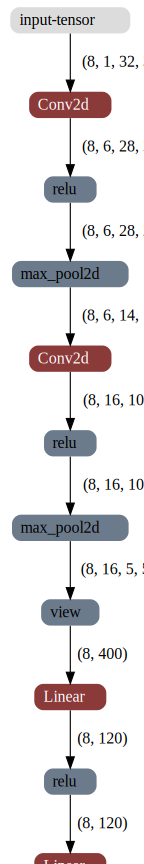

In [7]:
from IPython.display import SVG

# Display the SVG
SVG(graph_svg)

If you look at the `get_graph` function call above again, you will notice that we used the `filter_by` and `filter_value` arguments to highlight the graph nodes that have an RMS value less than 0.5 (shown in red). This is one example of how you can identify low-importance weights in the network. We will use this information to decide which weights to prune.

### Channel Pruning

The pruning package also provides channel pruning strategies that prune entire channels in Conv2D and optionally Linear layers. The available channel pruning strategies are:

- **Weight Norm Channel**: Prunes channels in Conv2D and optionally Linear layers based on the norm of their weights.
- **Activation Norm Channel**: Prunes channels based on the norm of their output activations, offering a dynamic pruning strategy.

There are two ways to prune channels: by specifying the number of channels to prune or by specifying the fraction of channels to prune. The `prune_channels` function allows you to prune channels in a model using the specified channel pruning strategy.

In [8]:
# Prune output channels of conv1 layer of the model and verfy the model
num_channels_prune = 2

# Prune the model
print("Before Pruning:", model.conv1)
pruned_mod, _, _ = prune_output_channels_by_rms(
    model.conv1,
    conv_channelwise_rms(model.conv1, rms_dim="op_channels"),
    num_channels_prune,
)

print("After Pruning:", pruned_mod)

Before Pruning: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
After Pruning: Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))


As you can see, the `prune_output_channels*` function removed the specified number of channels (2) from the layer, based on the filter criteria (least RMS values in this case). The `model.conv1` layer now has 4 output channels instead of 6. However, since this layer is connected to other layers, the input channels of the next layer (`model.conv2`) should also be reduced for the model to remain consistent.

The `prune_input_channels*` function is used to prune the input channels of a layer. In this case, we prune the input channels of the `model.conv2` layer to match the output channels of the `model.conv1` layer. We also provide a utility function `verify_model_consistency` to check if the model is consistent after channel pruning.

In [9]:
# Verify the pruned model
failed_node = verify_model(model, torch.randn(input_shape), graph)
print(failed_node)

126752954022448


One graph node with ID 137800826759552 failed. This is the `model.conv2` layer, which is now inconsistent with the pruned `model.conv1` layer. The input channels of the `model.conv2` layer should be reduced to match the output channels of the `model.conv1` layer.

In [10]:
# Prune output channels of conv1 layer of the model and verfy the model
num_channels_prune = 2

# Prune the model
print("Before Pruning:", model.conv2)
pruned_mod, _, _ = prune_input_channels_by_rms(
    model.conv2,
    conv_channelwise_rms(model.conv2, rms_dim="ip_channels"),
    num_channels_prune,
)

print("After Pruning:", pruned_mod)

Before Pruning: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
After Pruning: Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))


We can verify the model consistency again:

In [11]:
failed_node = verify_model(model, torch.randn(input_shape), graph)
print(failed_node)

None


This time, the model is consistent after channel pruning. The `model.conv2` layer now has 4 input channels, which matches the output channels of the `model.conv1` layer.

### Global Pruning
- **Random**: Randomly zeroes out a fraction of weights across the entire network.
- **Global Magnitude**: Prunes the least important weights across the entire network based on their absolute values.
- **Global Magnitude-Gradient**: Prunes weights globally based on a combination of their absolute values and gradients.
- **Global Activation-Magnitude**: Prunes weights globally based on a combination of their absolute values and corresponding activations.

### Layerwise (Local) Pruning
- **Layerwise Magnitude**: Prunes the least important weights within each individual layer based on their absolute values.
- **Layerwise Magnitude-Gradient**: Prunes weights within each layer based on a combination of their absolute values and gradients.
- **Layerwise Activation-Magnitude**: Prunes weights within each layer based on a combination of their absolute values and corresponding activations.